In [ ]:
# Whole dataset
! gdown 1atKYBZ9Pq3-zT0_BC_nZqMx0W-wjEW01 # all training data
! gdown 1FhT3m_ApKzX615JzshB5-d-j6S91-6oz # all validation data
! gdown 16p0td9GgJRb9AP8i4HlX-xZGI2u849uA # all testing data

! mkdir open_llm
! mv train.jsonl valid.jsonl test.jsonl open_llm/

Downloading...
From (original): https://drive.google.com/uc?id=1atKYBZ9Pq3-zT0_BC_nZqMx0W-wjEW01
From (redirected): https://drive.google.com/uc?id=1atKYBZ9Pq3-zT0_BC_nZqMx0W-wjEW01&confirm=t&uuid=09bc5af2-80a0-46c1-9127-5042d4c3ace2
To: /content/train.jsonl
100% 292M/292M [00:04<00:00, 63.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FhT3m_ApKzX615JzshB5-d-j6S91-6oz
To: /content/valid.jsonl
100% 55.1M/55.1M [00:00<00:00, 247MB/s]
Downloading...
From: https://drive.google.com/uc?id=16p0td9GgJRb9AP8i4HlX-xZGI2u849uA
To: /content/test.jsonl
100% 39.1M/39.1M [00:01<00:00, 24.0MB/s]
mkdir: cannot create directory ‘open_llm’: File exists


In [ ]:
!pip install lime

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_score, recall_score

import warnings

# Suppress FutureWarning related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
df_train = pd.read_json("open_llm/train.jsonl", lines=True)

df_test = pd.read_json("open_llm/test.jsonl", lines=True)

df_train

uid  \
0           [urlsf_subset00]-[15]   
1           [urlsf_subset00]-[15]   
2           [urlsf_subset00]-[83]   
3           [urlsf_subset00]-[83]   
4           [urlsf_subset00]-[89]   
...                           ...   
101279  [urlsf_subset05]-[389773]   
101280  [urlsf_subset05]-[389814]   
101281  [urlsf_subset05]-[389814]   
101282  [urlsf_subset05]-[389832]   
101283  [urlsf_subset05]-[389832]   

                                                     text  \
0       The dangers of Illinois as a ‘right to work’ s...   
1       The governor of Illinois, Gov. Rauner, has req...   
2       Check current weather conditions\n\nIt’s going...   
3       Check current weather conditions It’s going to...   
4       On Thursday, the president of the United State...   
...                                                   ...   
101279  Halifax Water has imposed mandatory water cons...   
101280  Less than a month into his tenure, Donald Trum...   
101281  Less than a month into his tenure, Donald Trum...   
101282  Georgia antagonists love to cite a well-worn q...   
101283  Many Georgia detractors are quick to reference...   

                                               extra   source  label  
0       {'source': 'openweb', 'variant': 'original'}  openweb      0  
1       {'source': 'chatgpt', 'variant': 'original'}  chatgpt      1  
2       {'source': 'openweb', 'variant': 'original'}  openweb      0  
3         {'variant': 'original', 'source': 'llama'}    llama      1  
4       {'source': 'openweb', 'variant': 'original'}  openweb      0  
...                                              ...      ...    ...  
101279  {'source': 'chatgpt', 'variant': 'original'}  chatgpt      1  
101280  {'source': 'openweb', 'variant': 'original'}  openweb      0  
101281    {'variant': 'original', 'source': 'llama'}    llama      1  
101282  {'source': 'openweb', 'variant': 'original'}  openweb      0  
101283  {'source': 'chatgpt', 'variant': 'original'}  chatgpt      1  

[101284 rows x 5 columns]

In [ ]:
def text_process(mess):
    """
    Process text to:
    1. Remove punctuation (including all Unicode quotes)
    2. Convert text to lowercase
    3. Return cleaned text without removing stopwords
    """
    mess = re.sub(r"[^\w\s]", "", mess)

    mess = mess.lower()

    return mess

In [ ]:
df_train['text'] = df_train['text'].apply(text_process)
df_test['text'] = df_test['text'].apply(text_process)

In [ ]:
X_train_df = df_train['text']
y_train_df = df_train['label']

X_test_df = df_test['text']
y_test_df = df_test['label']

In [ ]:
# instantiate the vectorizer
vect = CountVectorizer()

X_train_dtm = vect.fit_transform(X_train_df)

print(type(X_train_dtm), X_train_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (101284, 547607)


In [ ]:
logreg = LogisticRegression(C=0.1, max_iter=200, penalty='l1', solver='liblinear', random_state=42)

# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train_df)

CPU times: user 14.5 s, sys: 459 ms, total: 15 s
Wall time: 14.9 s


LogisticRegression(C=0.1, max_iter=200, penalty='l1', random_state=42,
                   solver='liblinear')

In [ ]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_df)

print(type(X_test_dtm), X_test_dtm.shape)

# make class predictions for X_test_dtm
y_pred = logreg.predict(X_test_dtm)

<class 'scipy.sparse._csr.csr_matrix'> (13952, 547607)


In [ ]:
print('Accuracy: ', accuracy_score(y_test_df, y_pred))
print('F1 score: ', f1_score(y_test_df, y_pred))
print('Precision: ', precision_score(y_test_df, y_pred))
print('Recall: ', recall_score(y_test_df, y_pred))

Accuracy:  0.8853211009174312
F1 score:  0.8874032371569317
Precision:  0.8715786563450373
Recall:  0.9038130733944955


In [ ]:
df_preds = pd.DataFrame({'true_label': y_test_df, 'predicted_label': y_pred})
df_preds[:20]

true_label  predicted_label
0            0                0
1            1                1
2            0                0
3            1                1
4            0                0
5            1                1
6            0                0
7            1                1
8            0                0
9            1                1
10           0                0
11           1                0
12           0                0
13           1                1
14           0                0
15           1                1
16           0                0
17           1                1
18           0                0
19           1                1

### SHAP

In [ ]:
import shap

In [ ]:
subset_X_test_df = X_test_df.head(3000)
subset_y_test_df = y_test_df.loc[subset_X_test_df.index]

subset_X_test_dtm = vect.transform(subset_X_test_df)

In [ ]:
subset_X_test_df.iloc[0]

'media playback is unsupported on your device media caption hungarian prime minister viktor orban its a serious ecological catastrophe\n\ntoxic red sludge from a spill at an industrial plant in hungary has reached the river danube officials say\n\nthey said alkaline levels that killed all fish in one river were now greatly reduced but were being monitored\n\npm viktor orban called the spill an ecological tragedy there are fears the mud which burst out of a reservoir on monday could poison the danube\n\ncountries downstream from hungary including croatia serbia and romania are drawing up emergency plans\n\na million cubic metres 35m cu ft of the sludge spilled from a reservoir at an alumina plant in ajka in western hungary four people were killed and about 100 injured\n\nthe mud also caused massive damage in nearby villages and towns as well as a wide swathe of farmland\n\nno victory declaration\n\ndisaster official tibor dobson said all life in the marcal river which feeds the danube h

In [ ]:
subset_y_test_df.iloc[0]

0

In [ ]:
import shap

explainer = shap.Explainer(logreg, X_train_dtm)

subset_X_test_dtm_dense = subset_X_test_dtm.toarray()

shap_values = explainer(subset_X_test_dtm_dense)

feature_names = vect.get_feature_names_out()


LinearExplainer explainer: 3001it [00:14, 61.45it/s]                           


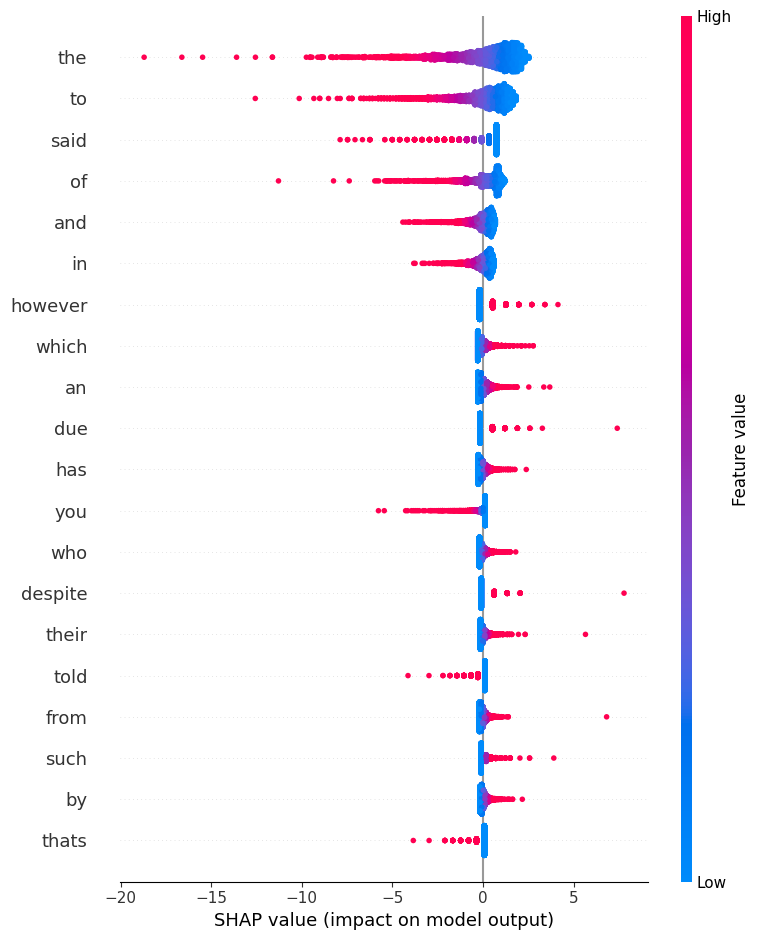

In [ ]:
shap.summary_plot(shap_values, subset_X_test_dtm_dense, feature_names=feature_names)


In [ ]:
# Convert SHAP values and data to dense format
shap_values_dense = shap_values.values  # SHAP values for all samples in the subset
base_values = shap_values.base_values  # Base values for all samples in the subset
data_dense = subset_X_test_dtm.toarray()  # Dense representation of input data

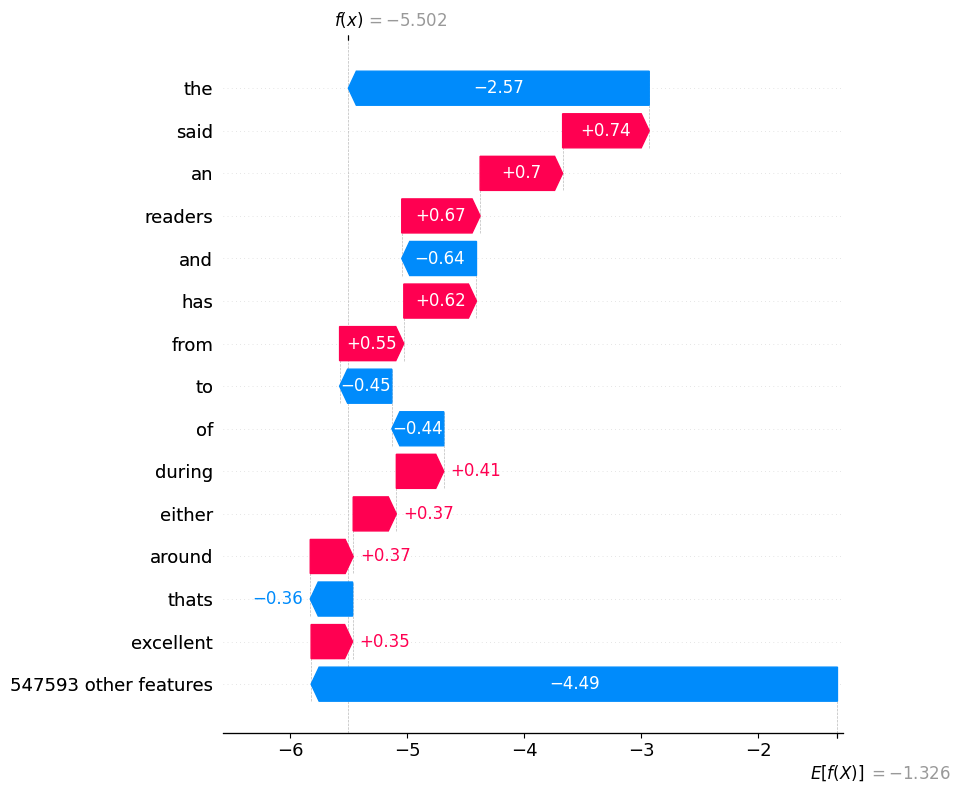

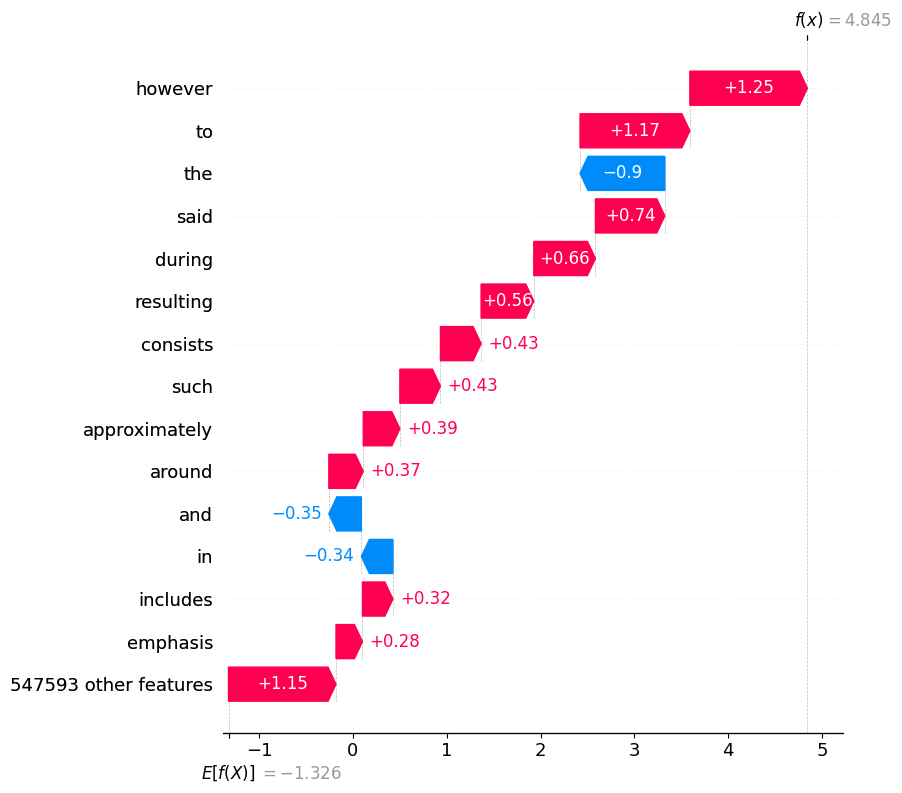

In [ ]:
# Generate SHAP waterfall plot for the 8th index (label 0)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_dense[8],
        base_values=base_values[8],
        feature_names=feature_names,
    ),
    max_display=15
)

# Generate SHAP waterfall plot for the 9th index (label 1)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_dense[9],
        base_values=base_values[9],
        feature_names=feature_names
    ),
    max_display=15
)

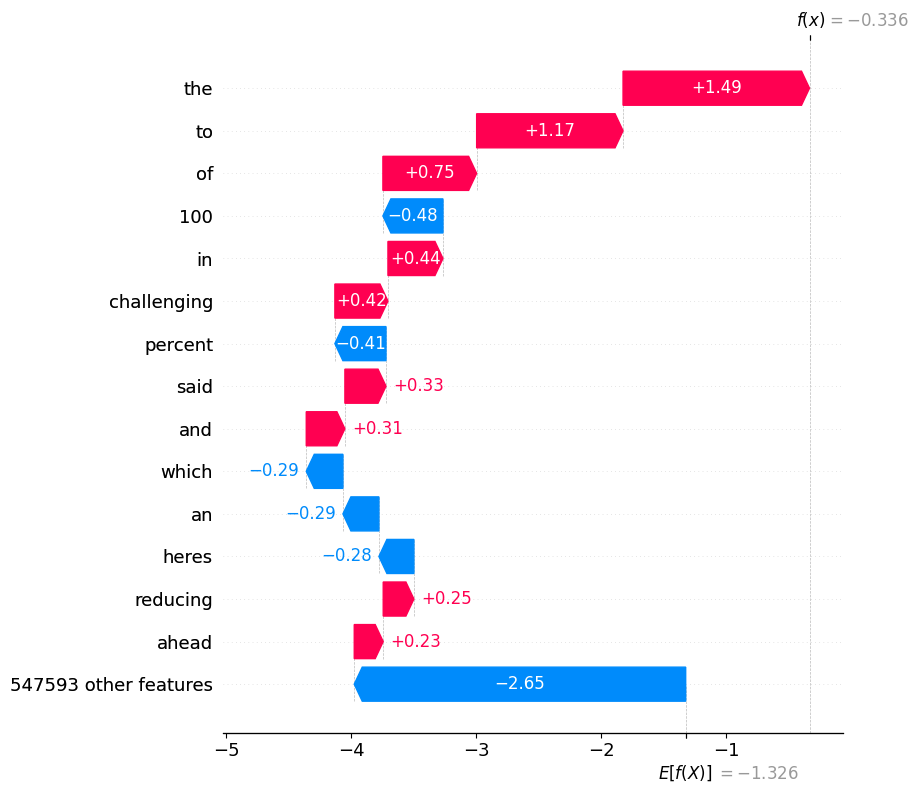

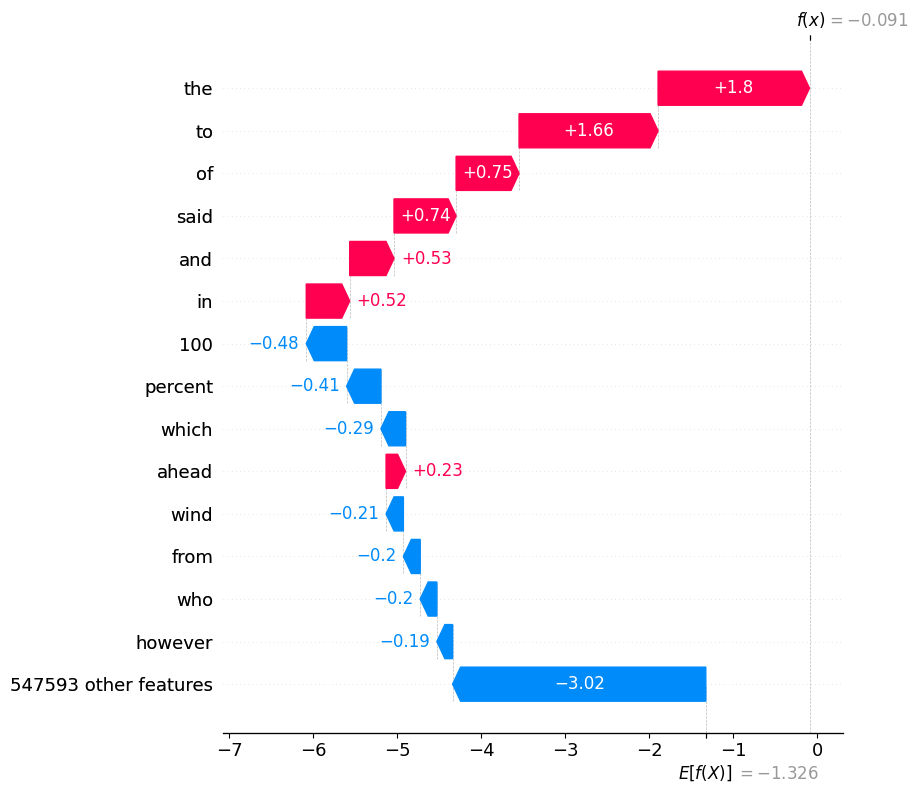

In [ ]:
# Generate SHAP waterfall plot for the 8th index (label 0)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_dense[10],
        base_values=base_values[10],
        feature_names=feature_names,
    ),
    max_display=15
)

# Generate SHAP waterfall plot for the 9th index (label 1)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_dense[11],
        base_values=base_values[11],
        feature_names=feature_names
    ),
    max_display=15
)

In [ ]:
# Print sum of Shap Values
for i in range(25):
    print(f"Sum of SHAP values for sample {i}:", sum(shap_values.values[i]))

Expected value (E(f(X))) for sample 0 : -1.3255073826528148
Model output (f(X)) for sample 0 : [ 0.  0. -0. ...  0.  0.  0.]
Sum of SHAP values for sample 0 : 725849.6020731874
Sum of SHAP values for sample 0: -7.5192118237163985
Sum of SHAP values for sample 1: 4.581182017383264
Sum of SHAP values for sample 2: -0.9708311874347647
Sum of SHAP values for sample 3: 1.6801252942927989
Sum of SHAP values for sample 4: -13.640437842929511
Sum of SHAP values for sample 5: 2.9474778762933678
Sum of SHAP values for sample 6: -11.67292270525049
Sum of SHAP values for sample 7: 2.3031441981765397
Sum of SHAP values for sample 8: -4.176121703170917
Sum of SHAP values for sample 9: 6.170048597640674
Sum of SHAP values for sample 10: 0.9899753416459847
Sum of SHAP values for sample 11: 1.2349520525309223
Sum of SHAP values for sample 12: -0.14841563647895664
Sum of SHAP values for sample 13: 5.303553387930207
Sum of SHAP values for sample 14: -9.45710918588298
Sum of SHAP values for sample 15: 6.5

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=logreg.classes_)
for i, sample in enumerate(subset_X_test_df[0:2]):
    explanation = explainer.explain_instance(
        text_instance=sample,
        classifier_fn=lambda x: logreg.predict_proba(vect.transform(x))
    )
    explanation.show_in_notebook()

In [ ]:
for i, sample in enumerate(subset_X_test_df[10:12]):
    explanation = explainer.explain_instance(
        text_instance=sample,
        classifier_fn=lambda x: logreg.predict_proba(vect.transform(x))
    )
    explanation.show_in_notebook()